<a href="https://colab.research.google.com/github/mildsupitcha25/MachineLearning_phishing_email/blob/main/ML_Phishing_Project_Final_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 28.6 MB/s eta 0:00:00

=== Evaluation Summary ===


,Model,Threshold,ROC-AUC,PR-AUC,Accuracy,Precision,Recall,F1
4,XGBoost,0.844280,0.982249,0.983826,0.884615,0.916667,0.846154,0.880000
5,CatBoost,0.893600,0.982249,0.983826,0.884615,0.916667,0.846154,0.880000
2,RandomForest,0.620000,0.958580,0.949330,0.846154,0.909091,0.769231,0.833333
3,NaiveBayes,0.991785,0.857988,0.780809,0.769231,0.705882,0.923077,0.800000
1,SVM,0.087857,0.674556,0.645107,0.576923,0.541667,1.000000,0.702703
0,Logistic,0.083168,0.650888,0.631547,0.538462,0.521739,0.923077,0.666667



=== Confusion Matrices (Test Set) ===


,Pred_Legitimate,Pred_Phishing
Actual_Legitimate,2,11
Actual_Phishing,1,12


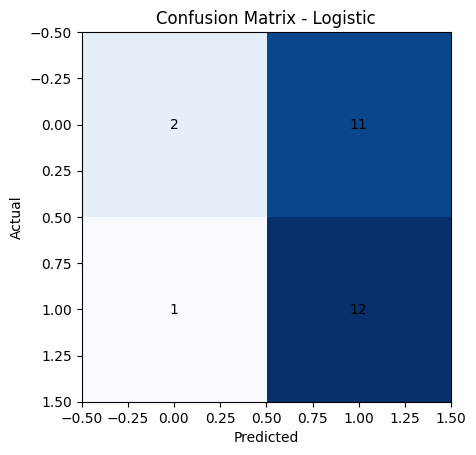

,Pred_Legitimate,Pred_Phishing
Actual_Legitimate,2,11
Actual_Phishing,0,13


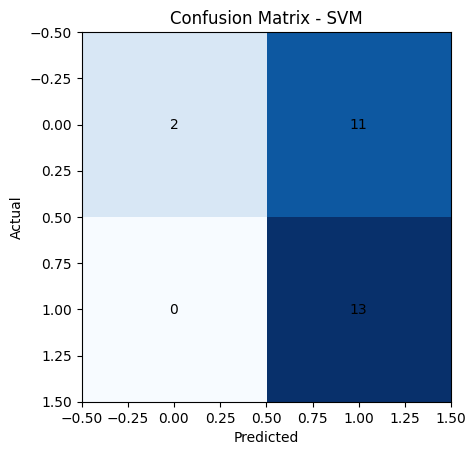

,Pred_Legitimate,Pred_Phishing
Actual_Legitimate,12,1
Actual_Phishing,3,10


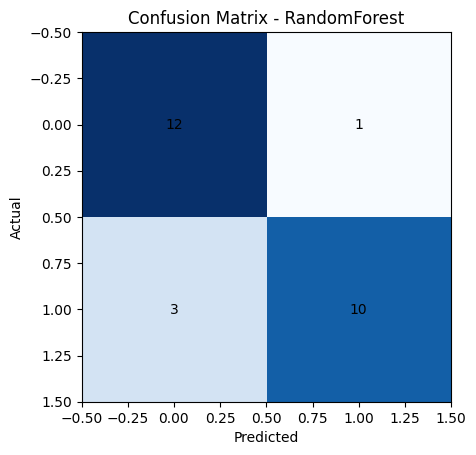

,Pred_Legitimate,Pred_Phishing
Actual_Legitimate,8,5
Actual_Phishing,1,12


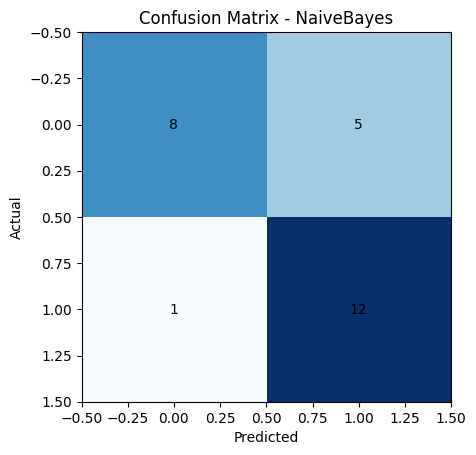

,Pred_Legitimate,Pred_Phishing
Actual_Legitimate,12,1
Actual_Phishing,2,11


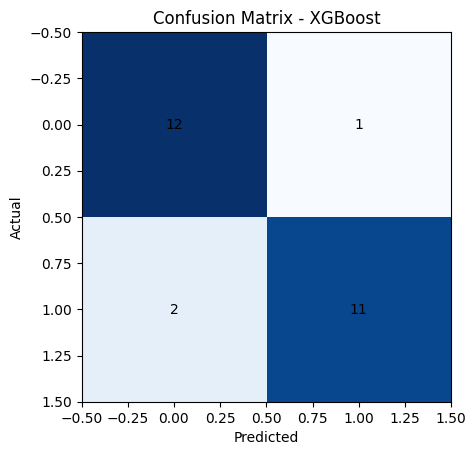

,Pred_Legitimate,Pred_Phishing
Actual_Legitimate,12,1
Actual_Phishing,2,11


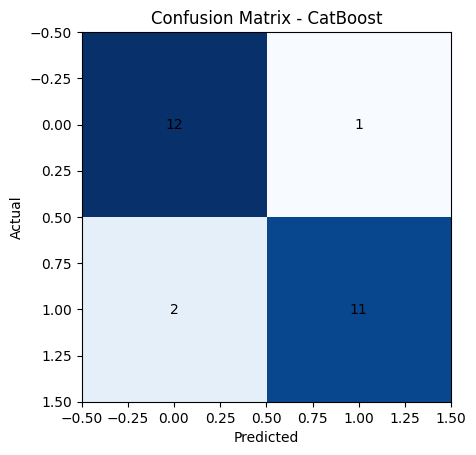

In [1]:
# ==============================
# Full FAST pipeline with Hyperparameter & Threshold tuning
# + Refit + DataFrame results + Confusion Matrices
# ==============================

# 0) Install
!pip -q install xgboost catboost optuna

# 1) Imports + quiet config
import warnings, optuna
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

import pandas as pd
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, roc_curve,
    fbeta_score, average_precision_score, confusion_matrix
)
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# 2) Data URLs
TRAIN_URL = "https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv"
TEST_URL  = "https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test.csv"

# 3) Load data
train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)

# 4) Feature engineering
def add_features(df):
    text = df["Subject"].fillna("") + " " + df["Body"].fillna("")
    df["FullText"] = text
    df["char_count"] = text.str.len()
    df["word_count"] = text.str.split().str.len()
    df["upper_count"] = text.apply(lambda x: sum(1 for c in x if c.isupper()))
    df["link_count"] = text.str.count(r"http|www")
    df["upper_ratio"] = df["upper_count"] / (df["char_count"] + 1e-6)
    return df

train_df = add_features(train_df)
test_df  = add_features(test_df)

label_map = {"Legitimate": 0, "Phishing": 1}
train_df["label_num"] = train_df["Label"].map(label_map)

test_has_label = False
if "Label" in test_df.columns:
    test_df["label_num"] = test_df["Label"].map(label_map)
    test_has_label = True

# 5) TF-IDF
num_cols = ["char_count","word_count","upper_count","link_count","upper_ratio"]

word_vec = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=20000)
char_vec = TfidfVectorizer(analyzer="char", ngram_range=(3,5), max_features=15000)

Xw = word_vec.fit_transform(train_df["FullText"])
Xc = char_vec.fit_transform(train_df["FullText"])
Xn = train_df[num_cols].values
X_all = hstack([Xw, Xc, Xn]).tocsr()

Xw_test = word_vec.transform(test_df["FullText"])
Xc_test = char_vec.transform(test_df["FullText"])
Xn_test = test_df[num_cols].values
X_test_all = hstack([Xw_test, Xc_test, Xn_test]).tocsr()

y = train_df["label_num"].values
y_test = test_df["label_num"].values if test_has_label else None

# 6) Train / Val split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y, test_size=0.2, stratify=y, random_state=42
)

# Threshold tuning helper
def tune_threshold(y_true, prob, target_recall=0.95):
    prec, rec, thr = precision_recall_curve(y_true, prob)
    best_t, best_p = None, -1
    for p, r, t in zip(prec[:-1], rec[:-1], thr):
        if r >= target_recall and p > best_p:
            best_p, best_t = p, t
    if best_t is not None:
        return best_t
    thresholds = np.linspace(0.05, 0.95, 91)
    f2s = [fbeta_score(y_true, (prob>=t).astype(int), beta=2) for t in thresholds]
    return float(thresholds[np.argmax(f2s)])

final_models = {}
model_thresholds = {}

# ---------------- Logistic ----------------
rs = RandomizedSearchCV(
    LogisticRegression(solver="saga", class_weight="balanced", max_iter=5000),
    {"C": np.logspace(-1, 1, 7)},
    n_iter=4, scoring="recall", cv=3, n_jobs=-1
)
rs.fit(X_tr, y_tr)
best_log = rs.best_estimator_
thr = tune_threshold(y_val, best_log.predict_proba(X_val)[:,1])
final_log = LogisticRegression(
    solver="saga", class_weight="balanced", max_iter=5000,
    C=rs.best_params_["C"]
).fit(X_all, y)

final_models["Logistic"] = final_log
model_thresholds["Logistic"] = thr

# ---------------- SVM ----------------
svm_val = CalibratedClassifierCV(LinearSVC(class_weight="balanced"), cv=3)
svm_val.fit(X_tr, y_tr)
thr = tune_threshold(y_val, svm_val.predict_proba(X_val)[:,1])
svm_full = CalibratedClassifierCV(LinearSVC(class_weight="balanced"), cv=3)
svm_full.fit(X_all, y)

final_models["SVM"] = svm_full
model_thresholds["SVM"] = thr

# ---------------- RandomForest ----------------
rs_rf = RandomizedSearchCV(
    RandomForestClassifier(class_weight="balanced", n_jobs=-1),
    {"n_estimators":[100,200], "max_depth":[8,12]},
    n_iter=3, scoring="recall", cv=3, n_jobs=-1
)
rs_rf.fit(X_tr, y_tr)
best_rf = rs_rf.best_estimator_
thr = tune_threshold(y_val, best_rf.predict_proba(X_val)[:,1])

rf_full = RandomForestClassifier(
    **rs_rf.best_params_, class_weight="balanced", n_jobs=-1
).fit(X_all, y)

final_models["RandomForest"] = rf_full
model_thresholds["RandomForest"] = thr

# ---------------- Naive Bayes ----------------
nb_val = MultinomialNB().fit(X_tr, y_tr)
thr = tune_threshold(y_val, nb_val.predict_proba(X_val)[:,1])
nb_full = MultinomialNB().fit(X_all, y)

final_models["NaiveBayes"] = nb_full
model_thresholds["NaiveBayes"] = thr

# ---------------- XGBoost ----------------
xgb = XGBClassifier(
    n_estimators=180, max_depth=4, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    eval_metric="auc", tree_method="hist", random_state=42
)
xgb_val = xgb.fit(X_tr, y_tr)
thr = tune_threshold(y_val, xgb_val.predict_proba(X_val)[:,1])
xgb_full = XGBClassifier(**xgb.get_params()).fit(X_all, y)

final_models["XGBoost"] = xgb_full
model_thresholds["XGBoost"] = thr

# ---------------- CatBoost ----------------
cb = CatBoostClassifier(
    iterations=300, depth=6, learning_rate=0.05,
    loss_function="Logloss", verbose=False, random_state=42
)
cb_val = cb.fit(X_tr, y_tr)
thr = tune_threshold(y_val, cb_val.predict_proba(X_val)[:,1])
cb_full = CatBoostClassifier(**cb.get_params()).fit(X_all, y)

final_models["CatBoost"] = cb_full
model_thresholds["CatBoost"] = thr

# ======================
# TEST EVALUATION
# ======================
rows = []
pred_df = pd.DataFrame()

for name, model in final_models.items():
    prob = model.predict_proba(X_test_all)[:,1]
    thr = model_thresholds[name]
    pred = (prob >= thr).astype(int)

    pred_df[f"{name}_prob"] = prob
    pred_df[f"{name}_pred"] = pred

    rows.append({
        "Model": name,
        "Threshold": thr,
        "ROC-AUC": roc_auc_score(y_test, prob),
        "PR-AUC": average_precision_score(y_test, prob),
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred),
        "F1": f1_score(y_test, pred)
    })

results_df = pd.DataFrame(rows).sort_values("ROC-AUC", ascending=False)
print("\n=== Evaluation Summary ===")
display(results_df)

# ======================
# CONFUSION MATRICES
# ======================
print("\n=== Confusion Matrices (Test Set) ===")
for name in final_models.keys():
    cm = confusion_matrix(y_test, pred_df[f"{name}_pred"])
    cm_df = pd.DataFrame(
        cm,
        index=["Actual_Legitimate","Actual_Phishing"],
        columns=["Pred_Legitimate","Pred_Phishing"]
    )
    display(cm_df)

    plt.imshow(cm, cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i,j], ha="center", va="center")
    plt.show()